# Couple Candlesticks - Strategy - Backtesting 

### Import Library

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
# from backtesting._plotting import set_bokeh_output
# set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
# import warnings
# warnings.filterwarnings('ignore')

/home/zuongthao/PycharmProjects/algo-stock/venv/lib/python3.11/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [3]:
data = dataset.copy()

In [4]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']
# data = data[data.index > '2024-01-01 00:00:00']

In [5]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-14 14:15:00,1343.0,1343.0,1340.3,1341.3,7141
2025-02-14 14:20:00,1340.9,1341.9,1340.5,1341.4,4593
2025-02-14 14:25:00,1341.1,1342.5,1340.7,1342.5,4207


In [6]:
def set_condition_1(r):
    cond = ''
    if r['Open'] > r['Close'] and r['Close'] >= r['Low'] + 0.1:
        # Do va co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] and r['Close'] <= r['High'] - 0.1:
        # Xanh va co bong nen tren
        cond = 'long'
    return cond

def set_condition_2(r):
    cond = ''
    if r['Open'] > r['Close'] and r['Close'] == r['Low'] and r['Low'] < r['prev_low']:
        # Do va khong co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] and r['Close'] == r['High']  and r['High'] > r['prev_high']:
        # Xanh va khong co bong nen tren
        cond = 'long'
    return cond

def get_signal(r):
    signal = ''
    if r['condition_1'] == 'short' and r['condition_2'] == 'short':
        signal = 'short'
    elif r['condition_1'] == 'long' and r['condition_2'] == 'long':
        signal = 'long'
    return signal

In [7]:
def prepare_data(data):
    data['prev_low'] = data['Low'].shift(1)
    data['prev_high'] = data['High'].shift(1)
    data['max_5'] = data['High'].rolling(5).max()
    data['min_5'] = data['Low'].rolling(5).min()
    data['condition_1'] = data.apply(lambda r: set_condition_1(r), axis=1)
    data['condition_1'] = data['condition_1'].shift(1)
    data['condition_2'] = data.apply(lambda r: set_condition_2(r), axis=1)
    data['signal'] = data.apply(lambda r: get_signal(r), axis=1)
    return data

In [8]:
class CoupleCandlesticks(Strategy):
    max_sl = 3.5
    trailing_sl = 4.5
    tp_step = 20
    def init(self):
        self._broker._cash = 1500
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
                return
                
        if current_time.hour == 14 and current_time.minute >= 30:
            return

        close_price = self.data.Close[-1]
        if self.position.is_long:
            max_5 = self.data.max_5[-1]
            if close_price < max_5 - self.trailing_sl:
                self.position.close()
        elif self.position.is_short:
            min_5 = self.data.min_5[-1]
            if close_price > min_5 + self.trailing_sl:
                self.position.close()

        if self.position:
            return  
        signal = self.data.signal[-1]
        if signal == 'long':
            buy_price = close_price
            min_5 = self.data.min_5[-1]
            tmp_risk = buy_price - min_5
            risk = min(tmp_risk, self.max_sl)
            sl = buy_price - risk
            tp = buy_price + self.tp_step
            self.buy(size=1, sl=sl, tp=tp)
        elif signal == 'short':
            sell_price = close_price
            max_5 = self.data.max_5[-1]
            tmp_risk = max_5 - sell_price
            risk = min(tmp_risk, self.max_sl)
            sl = sell_price + risk
            tp = sell_price - self.tp_step
            self.sell(size=1, sl=sl, tp=tp)

In [9]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [10]:
# prepared_data[(prepared_data.index > '2024-11-06 00:00:00') & (prepared_data.index < '2024-11-06 15:00:00')]

In [11]:
bt = Backtest(prepared_data, CoupleCandlesticks, commission=.0003, exclusive_orders=True)
stats = bt.run()
# bt.plot()
print(stats)

Start                     2020-11-02 09:20:00
End                       2025-02-14 14:45:00
Duration                   1565 days 05:25:00
Exposure Time [%]                   33.798965
Equity Final [$]                   2235.51119
Equity Peak [$]                    2251.80005
Return [%]                          49.034079
Buy & Hold Return [%]               49.387664
Return (Ann.) [%]                    9.944504
Volatility (Ann.) [%]                6.889147
Sharpe Ratio                         1.443503
Sortino Ratio                        3.163325
Calmar Ratio                          2.01743
Max. Drawdown [%]                   -4.929294
Avg. Drawdown [%]                   -0.339574
Max. Drawdown Duration      370 days 01:15:00
Avg. Drawdown Duration        6 days 00:58:00
# Trades                                 1633
Win Rate [%]                        35.394979
Best Trade [%]                       2.295959
Worst Trade [%]                     -0.920813
Avg. Trade [%]                    

In [12]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,-1,10,11,899.63003,901.4,-1.76997,-0.001967,2020-11-02 10:10:00,2020-11-02 10:15:00,None,0 days 00:05:00
1,1,45,46,906.97201,904.0,-2.97201,-0.003277,2020-11-02 14:30:00,2020-11-02 14:45:00,None,0 days 00:15:00
2,-1,52,65,907.92754,909.4,-1.47246,-0.001622,2020-11-03 09:25:00,2020-11-03 10:30:00,None,0 days 01:05:00
3,-1,106,111,907.02781,908.8,-1.77219,-0.001954,2020-11-04 09:40:00,2020-11-04 10:05:00,None,0 days 00:25:00
4,1,112,146,909.37273,912.5,3.12727,0.003439,2020-11-04 10:10:00,2020-11-04 14:25:00,None,0 days 04:15:00
...,...,...,...,...,...,...,...,...,...,...,...
1628,1,54323,54324,1332.79972,1334.1,1.30028,0.000976,2025-02-11 14:30:00,2025-02-11 14:45:00,None,0 days 00:15:00
1629,-1,54330,54338,1339.19812,1341.4,-2.20188,-0.001644,2025-02-12 09:25:00,2025-02-12 10:05:00,None,0 days 00:40:00
1630,-1,54374,54375,1332.60010,1329.5,3.10010,0.002326,2025-02-12 14:30:00,2025-02-12 14:45:00,None,0 days 00:15:00
1631,1,54397,54425,1330.19894,1336.5,6.30106,0.004737,2025-02-13 10:45:00,2025-02-13 14:30:00,None,0 days 03:45:00


In [13]:
stats['_trades']['PnL'].sum()

735.5111900000553

In [14]:
trades = stats['_trades']

In [15]:
trades[trades.PnL > 0]['PnL'].sum()

3688.493920000019

In [16]:
trades['cum_sum'] = trades['PnL'].cumsum()
X = np.array(range(0, len(trades['cum_sum'])))
Y = trades['cum_sum']

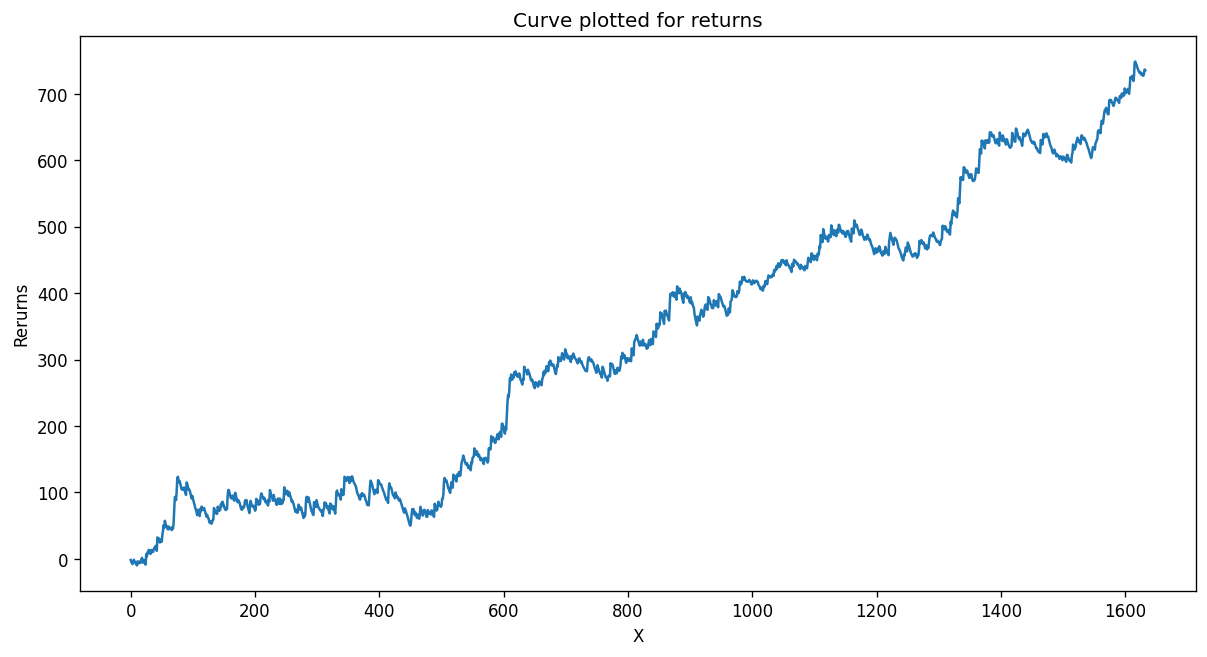

In [17]:
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()